In [27]:
import numpy as np
import pandas as pd
from scipy import signal 
import soundfile as sf
import simpleaudio as sa
import sounddevice as sd
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.titleweight'] = 'bold'

class SignalTB:
    """
        My signal toolbox (SignalTB)!
    """
    
    def __init__(self, x, fs):
        """
        Arguments:
            x: Time Series
            fs: Sample Frequency
        """
        self.fs = fs; # [hz]
        self.x = x    # time domain series
        self.X = None # frequency domain series
        self.sxx = None
        self.gxx = None
        self.gxx_rms_a = None
        self.gxx_linear_a = None
        self.signals = [self.x] #useful container
        
        self.N = self.x.shape[0]   # number of samples
        self.L = self.x.index[-1] - self.x.index[0]   # total time of signal [s]
        self.dt = self.L/self.N  # [s]
        self.df = self.fs/self.N
    
    def get_signals():
        return filter(lambda x: x is not None, [self.X, self.x, self.sxx, self.gxx])
    
    def my_fft(self):
        """
        Description:
            This method calculates the fft of a time domain signal using numpy's fft function and 
        adjusting it appropriately to multiplies it by dt.
        
        Returns:
            Series of frequency domain signal
        """
        freq = np.arange(-np.ceil(self.N/2)+1,
                         np.floor(self.N/2)+1) * self.df
        X = np.fft.fft(a=self.x.values, n=None, axis=-1, norm=None) * self.dt
        X = np.concatenate((X[int(np.floor(self.N/2))+1:],
                            X[0:int(np.floor(self.N/2))+1])) # rearrange the frequencies from standard form to sequential. Remember that 1:self.N//2 does not grab that second index value
        X = pd.Series(data=X,
                      index=freq,
                      name='X')
        self.X = X
        SignalTB.parseval_thrm(self.x,self.X,self.df,self.dt)  #check Parsevals thrm
        self.signals.append(self.X)
        return X
    
    @staticmethod
    def my_ifft(X, N, df, dt):
        """
        Description:
            This method calculates the ifft of a time domain signal using numpy's ifft function and 
        adjusting it appropriately to multiplies it by dt.
        
        Returns:
            Series of frequency domain signal
        """
        t = np.linspace(start=0, stop=N*dt, num=N, endpoint=True)
        X = X.values # these are in sequential, non standard form
        X = np.concatenate((X[int(np.ceil(N/2))-1:],
                            X[0:int(np.ceil(N/2))-1])) #put the fft values in standard form so ifft can accept it
        x = np.fft.ifft(a=X, n=None, axis=-1, norm=None) / dt
        SignalTB.parseval_thrm(x,X,df,dt)  #check Parsevals thrm
        return pd.Series(data=x,
                         index=t,
                         name='x2')
    
    @staticmethod
    def parseval_thrm(x, X, df, dt):
        """
        Description:
             Checks to make sure Parseval's Theorem holds between a time domain and FFT holds true

        Arguments:
            x: time domain signal
            X: frequency domain signal
        """
        x = np.absolute(x) #get rid of complex numbers to do calc
        X = np.absolute(X)
        td = round((x**2).sum() * dt, 1)
        fd = round((X**2).sum() * df, 1)
        assert td == fd , "Parseval Theorem not satisfied: {} != {}".format(td,fd)
        
    def sd(self):
        """
        Descrition:
            Spectral Density
        """
        sxx = np.abs(self.X)**2 / self.L; sxx.name = 'S_xx'; #display('sxx',sxx)
        # mean squared check
        X_ms = round(1/self.L * np.sum(np.abs(self.X)**2)*self.df,1)
        sxx_ms = round(np.sum(sxx)*self.df,1)
        assert X_ms == sxx_ms, 'Mean Squared Value Error: {} != {}'.format(X_ms,sxx_ms)
        self.sxx = sxx
        self.signals.append(self.sxx)
        
        #gxx
        freq = np.arange(0, np.floor(self.N/2)+1) * self.df; #display('freq',freq)
        i_zero = int(np.ceil(self.N/2)-1); #display('i_zero',i_zero)

        X = self.sxx.values[i_zero:] * 2 #grab from the center value all the way to the end and double it
        X[0] = X[0]/2
        if self.N%2 == 0: X[-1] = X[-1]/2 #even
        gxx = pd.Series(data=X,
                          index=freq,
                          name='G_xx')

        # mean squared check
        gxx_ms = round(np.sum(gxx) * self.df,1)
        assert sxx_ms == gxx_ms, 'Mean Squared Value Error: {} != {}'.format(sxx_ms,gxx_ms)
        self.gxx = gxx # uts of db
        self.signals.append(self.gxx)
        return self.sxx, self.gxx
    
    def rms_a(self, n_intervals = 16):
        """
            RMS Averaging for Gxx
        """
        frames=[]
        for i in range(1,n_intervals+1):
            x = self.x.iloc[int((i-1)*self.N/n_intervals):int(i*self.N/n_intervals)]
            m = SignalTB(x=x, fs=self.fs)
            m.my_fft(); #calc fft
            m.sd() #calculate sxx and gxx
            frames.append(m.gxx) #save each gxx for averaging
        assert len(frames) == n_intervals, 'Could not perfectly cut the number of samples by the n_interval: {}'.format(n_intervals)
        gxx_rms_a = pd.concat(frames,axis='columns').mean(axis='columns') # calculates the mean of at each row (frequency)
        gxx_rms_a.name = 'G_xx_rms_a'
        self.gxx_rms_a = gxx_rms_a
        self.signals.append(gxx_rms_a)
        return gxx_rms_a
    
    def linear_a(self, n_intervals = 16):
        """
            Linear Averaging for X, then calculation of Gxx
        """
        frames=[]
        for i in range(1,n_intervals+1):
            x = self.x.iloc[int((i-1)*self.N/n_intervals):int(i*self.N/n_intervals)]
            m = SignalTB(x=x, fs=self.fs)
            m.my_fft(); #calc fft
            frames.append(m.X) #save the fft
        assert len(frames) == n_intervals, 'Could not perfectly cut the number of samples by the n_interval: {}'.format(n_intervals)
        X_a = pd.concat(frames,axis='columns').mean(axis='columns') #average all the X's at each frequency

        #generate a temporary object so that you can perform computations
        m = SignalTB(x=self.x.iloc[int((i-1)*self.N/n_intervals):int(i*self.N/n_intervals)], fs=self.fs) # the time signal passed in doesn't mean anything, its just necessary to instatiate object
        m.X = X_a #set the new averaged X_a as the frequency domain signal in the temporary object
        m.sd()
        m.gxx.name = 'G_xx_linear_a'
        self.gxx_linear_a = m.gxx
        self.signals.append(m.gxx)
        return m.gxx

    def time_a(self, n_intervals = 16):
        """
            Time Averaging for x, then calculation of Gxx
        """
        frames=[]
        for i in range(1,n_intervals+1):
            x = self.x.iloc[int((i-1)*self.N/n_intervals):int(i*self.N/n_intervals)]
            x = pd.Series(data=x.values,
                          index=self.x.index[0:int(self.N/n_intervals)]) # make sure that all the objects have the same time index. This is important for taking the average and when we instatiate a new object.
            frames.append(x) #save the fft
        assert len(frames) == n_intervals, 'Could not perfectly cut the number of samples by the n_interval: {}'.format(n_intervals)
        x_a = pd.concat(frames,axis='columns').mean(axis='columns'); #display(x_a);
        
        m = SignalTB(x=x_a, fs=self.fs) #generate a temporary object
        m.my_fft()
        m.sd()
        m.gxx.name = 'G_xx_time_a'
        self.gxx_time_a = m.gxx
        self.signals.append(m.gxx)
        return m.gxx

    def spectrogram(self, n_intervals = 16, overlap = 0.25):
        """
            Spectrogram!
        """
        p_size = int(np.floor(self.N/n_intervals));#print('psize: {}'.format(p_size));print('n_intervals*p_size: {}'.format(n_intervals*p_size))
        x = self.x.iloc[0:int(n_intervals*p_size)]
        
        frames=[]
        for i in range(1,n_intervals+1):
            if i == 1:
                f = 0
                l = p_size
            else:
                f = l - int(np.floor(overlap*p_size))
                l = f + p_size
            sig = x.iloc[f:l]
            m = SignalTB(x=sig, fs=self.fs)
            m.my_fft();
            m.sd()
            r = (int((i-1)*self.N/n_intervals) + int(i*self.N/n_intervals))/2
            m.gxx.name = round(r*m.dt,2)  # name the slice at the middle
            frames.append(m.gxx)
        assert len(frames) == n_intervals, 'Could not perfectly cut the number of samples by the n_interval: {}'.format(n_intervals)
        gxx_df = pd.concat(frames,axis='columns').sort_index(ascending=False)
        gxx_df.name = 'Gxx_spectro'
        
        gxx_df.index = gxx_df.index.values.round(decimals=1)
        self.gxx_df = gxx_df
        self.signals.append(self.gxx_df)
        
        return gxx_df
    
    def plot_signals(self, xrange=None):
        """
        Description:
            Plots all of the signals in the self.signals container
            
        Returns:
            Nothing
        """

        for i, sig in enumerate(self.signals):
            if type(sig) != pd.DataFrame:
                if sig.dtype == complex: sig = np.absolute(sig) # ALWAYS the magnitude of this in case its a complex number
            fig = plt.figure(figsize=(10,5))
            plt.title(sig.name)
            if sig.name in ['x','x2','time domain signal']:
                plt.ylabel('x(t)'); plt.xlabel('t [s]')
            elif sig.name in ['X','S_xx','G_xx','G_xx_rms_a','G_xx_linear_a','G_xx_time_a']:
                sig = 10*np.log10(sig); plt.ylabel('X(f)'); plt.xlabel('f [Hz]'); #plt.ylim([-30:])
            elif sig.name in ['Gxx_spectro']:
                sns.heatmap(sig, cmap="jet"); plt.ylabel('f [Hz]'); plt.xlabel('t [s]')
                continue
            if xrange != None:
                sig[xrange[0]:xrange[1]].plot();
            else:
                sig.plot();
            plt.grid()

    #Useful functions to generate signals
    @staticmethod
    def impulse(N,L,Tp):
        x = np.zeros(N)
        x[0:int(N*Tp/L)] = 1
        x = pd.Series(data=x,
                      index=np.linspace(start=0, stop=L, num=N, endpoint=True, dtype=float),
                      name='x')
        return x
    
    @staticmethod
    def cw_sin(A,f,N,L,Tp):
        """
        Arguments:
            A: Amplitude
            f: Frequency of signal [hz]
            L: Total length of time [s]
            N: Number of points
            Tp: Pulse length
            
        Returns:
            Series
        """
        t = np.linspace(start=0, stop=L, num=N, endpoint=True, dtype=float)
        x = np.zeros(N)
        
        t_s = t[0:int(N*Tp/L)];
        x[0:int(N*Tp/L)] = A*np.sin(2*np.pi*f*t_s)
        
        return pd.Series(data=x,
                      index=t,
                      name='x')
    
    @staticmethod
    def lin_sin_s(A,N,L,Tp,f1,f2):
        """
        Arguments:
            A: Amplitude
            f: Frequency of signal [hz]
            L: Total length of time [s]
            N: Number of points
            Tp: Pulse length
            
        Returns:
            Series
        """
        t = np.linspace(start=0, stop=L, num=N, endpoint=True, dtype=float)
        x = np.zeros(N)
        
        t_s = t[0:int(N*Tp/L)];
        phi = 2*np.pi*( (f2-f1)/(2*Tp)*t_s**2+f1*t_s)
        x[0:int(N*Tp/L)] = A*np.sin(phi)
        
        return pd.Series(data=x,
                      index=t,
                      name='x')
    
    @staticmethod
    def log_sin_s(A,N,L,Tp,f1,f2):
        """
        Arguments:
            A: Amplitude
            L: Total length of time [s]
            N: Number of points
            Tp: Pulse length
            
        Returns:
            Series
        """
        t = np.linspace(start=0, stop=L, num=N, endpoint=True, dtype=float)
        x = np.zeros(N)
        
        t_s = t[0:int(N*Tp/L)];
        phi = 2*np.pi*f1*(f2/f1)**(t_s/Tp)*Tp/(np.log(f2/f1))-2*np.pi*f1*Tp/np.log(f2/f1)
        x[0:int(N*Tp/L)] =  A*np.sin(phi)
        
        x = pd.Series(data=x,
                      index=t,
                      name='x')
        return x
    
    @staticmethod
    def white_noise(N,L,Tp):
        """
        Arguments:
            L : Total length of time [s]
            N : Number of points
            
        Returns:
            Series
        """
        fs = N/L
        df = fs/N
        
        p = np.random.uniform(0,2*np.pi,int(N/2)-1) #random phase
        Z = 1*np.sin(p) + 1*np.cos(p)*1j #random complex numbers with magnitude of 1
        
        Z = np.concatenate((Z, np.array([0]), np.flip(np.conj(Z))))
        
        if N%2 == 0: Z = np.concatenate((Z, np.array([0])))
        
        freq = np.arange(-np.ceil(N/2)+1, np.floor(N/2)+1) * df
        X = pd.Series(data=Z,index=freq); #construct the full freq response
        x = SignalTB.my_ifft(X=X, N=N, df=df, dt=dt) # get the full time noise
        
        y = np.zeros(N,dtype=complex)
        y[0:int(N*Tp/L)] = x.values[0:int(N*Tp/L)] # take only a subset of the noisey signal and put it infront of all the zeros
        
        return pd.Series(data=np.real(y),
                         index=x.index,
                         name='x')
    
    @staticmethod
    def sin(A,f,L,N):
        """
        Arguments:
            A: Amplitude
            f: Frequency of signal [hz]
            L: Total length of time [s]
            N: Number of points
            
        Returns:
            Series
        """
        t = np.linspace(start=0, stop=L, num=N, endpoint=True, dtype=float)
        return pd.Series(data=A*np.sin(2*np.pi*f*t),
                         index=t,
                         name='x')

    @staticmethod
    def randn_sig(L,N):
        """
        Arguments:
            L : Total length of time [s]
            N : Number of points
            
        Returns:
            Series
        """
        return pd.Series(data=np.random.randn(N,),
                         index=np.linspace(start=0, stop=L, num=N, endpoint=True),
                         name='x')
    @staticmethod
    def csd(s0,s1):
        """
        Descrition:
            Cross Spectral Density
        """
        #calculate the fft of the objects
        s0.my_fft(); s1.my_fft()
        
        #sxy
        sxy = np.conj(s0.X)*s1.X / s0.L; sxy.name = 'S_xy';
        
        #gxy
        freq = np.arange(0, np.floor(s0.N/2)+1) * s0.df; #display('freq',freq)
        i_zero = int(np.ceil(s0.N/2)-1); #display('i_zero',i_zero)

        X = sxy.values[i_zero:] * 2 #grab from the center value all the way to the end and double it
        X[0] = X[0]/2
        if s0.N%2 == 0: X[-1] = X[-1]/2 #even
        gxy = pd.Series(data=X,
                        index=freq,
                        name='G_xy')
        return sxy, gxy
    
    @staticmethod
    def cross_corr(s0,s1):
        """
        Description:
            Cross correlation F^-1(Sxy)
        """
        sxy, gxy = SignalTB.csd(s0,s1)
        X = sxy.values # these are in sequential, non standard form
        X = np.concatenate((X[int(np.ceil(s0.N/2))-1:],
                            X[0:int(np.ceil(s0.N/2))-1])) #put the fft values in standard form so ifft can accept it
        x = np.fft.ifft(a=X, n=None, axis=-1, norm=None) / s0.dt
        SignalTB.parseval_thrm(x,X, s0.df, s0.dt)  #check Parsevals thrm
        x = np.concatenate((x[int(np.floor(s0.N/2))+1:],
                            x[0:int(np.floor(s0.N/2))+1])) #put the fft values in standard form so ifft can accept it
        t = np.arange(-np.ceil(s0.N/2)+1,np.floor(s0.N/2)+1) * s0.dt
        
        cross_corr = pd.Series(data=x,
                               index=t,
                               name='Cross Correlation')
        return cross_corr, sxy, gxy
    
    @staticmethod
    def pink_noise(N,L,Tp):
        """
        Arguments:
            L : Total length of time [s]
            N : Number of points
            
        Returns:
            Series
        """
        fs = N/L
        df = fs/N
        
        p = np.random.uniform(0,2*np.pi,int(N/2)-1) #random phase
        Z = 1*np.sin(p) + 1*np.cos(p)*1j #random complex numbers with magnitude of 1
        
        Z = np.concatenate((Z, np.array([0]), np.flip(np.conj(Z))))
        
        if N%2 == 0: Z = np.concatenate((Z, np.array([0])))

        freq = np.arange(-np.ceil(N/2)+1, np.floor(N/2)+1) * df
        freq[int(np.ceil(N/2))-1] = freq[int(np.ceil(N/2))-1] - 0.00001 #replace zero with slightly neg number
        mag = np.sqrt(np.abs(1/freq))
        Z = np.multiply(mag,Z)
        
        X = pd.Series(data=Z,index=freq); #construct the full freq response
        x = SignalTB.my_ifft(X=X, N=N, df=df, dt=dt) # get the full time noise
        
        y = np.zeros(N,dtype=complex)
        y[0:int(N*Tp/L)] = x.values[0:int(N*Tp/L)] # take only a subset of the noisey signal and put it infront of all the zeros
        
        return pd.Series(data=np.real(y),
                         index=x.index,
                         name='x')
    
    @staticmethod
    def butter_bandpass(lowcut, highcut, fs, order):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype='band')
        return b, a

    @staticmethod
    def butter_bandpass_filter(data, lowcut, highcut, fs, order):
        b, a = SignalTB.butter_bandpass(lowcut, highcut, fs, order)
        y = signal.lfilter(b, a, data)
        return y

    @staticmethod
    def filter_ha_hc(freq):
        w  = 2*np.pi*freq
        w1 = 2*np.pi*12194.22
        w2 = 2*np.pi*20.598997
        w3 = 2*np.pi*107.65265
        w4 = 2*np.pi*737.86223

        Hc = ( ( 1.0072*(1j*w)**2 * (w1)**2 ) / ( (w1+1j*w)**2 * (w2+1j*w)**2 ) )
        Ha = Hc * ( 1.250*(1j*w)**2 ) / ( (w3+1j*w)*(w4+1j*w) ) # why does Ha not have the same x intersept as the notes???
        
        Ha=pd.Series(data=Ha, index=freq)
        Hc=pd.Series(data=Hc, index=freq)
        return Ha, Hc
    
    @staticmethod
    def spl(x):
        ms = 1/len(x) * x.apply(lambda x: x**2).sum() #what are the units of this? I made this up
        pref = 20 # micropasc
        return 10*np.log10(ms/(pref**2))

# PART A

22.599589001464444

1.0589650343922026

/home/m4rz910/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/m4rz910/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


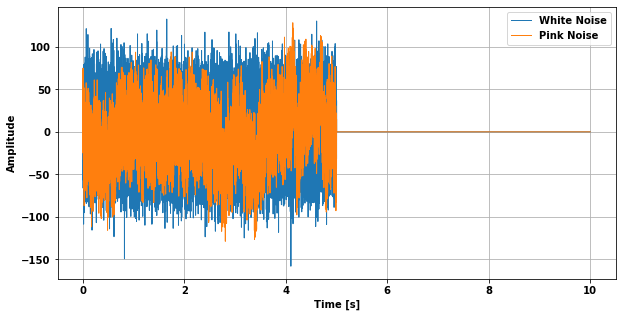

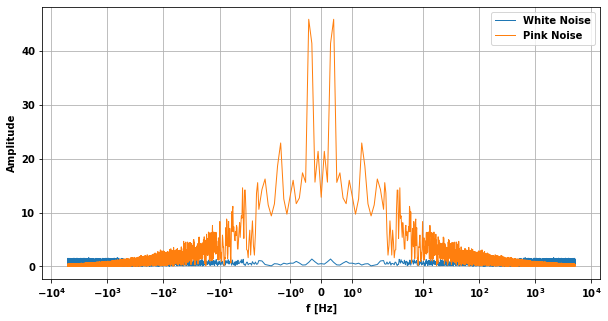

In [6]:
L = 10 # [s]
fs = 10240 # [hz]
N = int(L/(1/fs));  # generate the number of points based on the sampling frequency which is higher than the actual signal frequency
f_sin = 400;
df = fs/N
dt = L/N
Tp = 5

x0 = SignalTB.white_noise(N,L,Tp)
x1 = SignalTB.pink_noise(N,L,Tp)
rms0 = np.sqrt(1/len(x0) * x0.apply(lambda x: x**2).sum())
rms1 = np.sqrt(1/len(x1) * x1.apply(lambda x: x**2).sum())
display(rms0,rms1)
rms01 = rms0/rms1 # scale 1 to match rms of 0
x1 = rms01*x1

s0 = SignalTB(x=x0, fs=fs) #load into my signals object
s1 = SignalTB(x=x1, fs=fs)
s0.my_fft(); s1.my_fft();

fig = plt.figure(figsize=(10,5))
plt.plot(s0.x)
plt.plot(s1.x)
plt.ylabel('Amplitude'); plt.xlabel('Time [s]');plt.legend(['White Noise','Pink Noise']); plt.grid()
fig.savefig('./plots/hw6_timeseries.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(10,5))
plt.plot(np.abs(s0.X))
plt.plot(np.abs(s1.X))
plt.legend(['White Noise','Pink Noise']); plt.grid()
plt.ylabel('Amplitude'); plt.xlabel('f [Hz]'); plt.xscale('symlog');

# PART B

In [7]:
print('White Noise SPL: {}'.format(SignalTB.spl(s0.x)))
print('Pink Noise SPL:  {}'.format(SignalTB.spl(s1.x)))

White Noise SPL: 1.0614109085895342
Pink Noise SPL:  1.0614109085895365


# PART C: A&C Filters

/home/m4rz910/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/m4rz910/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


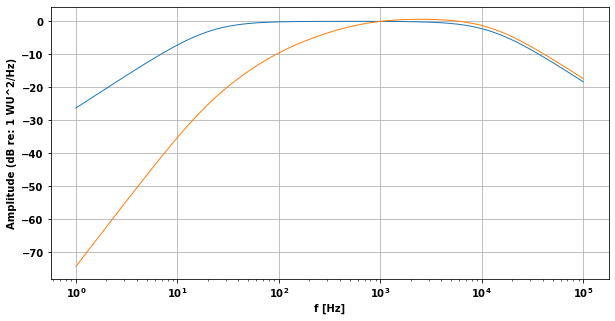

In [8]:
#testing filters
freq = np.arange(0, 100000)
Ha, Hc = SignalTB.filter_ha_hc(freq)

fig = plt.figure(figsize=(10,5))
plt.plot(freq, 10*np.log10(np.abs(Hc)))
plt.plot(freq, 10*np.log10(np.abs(Ha)))
plt.xscale('log'); plt.grid()
plt.ylabel('Amplitude (dB re: 1 WU^2/Hz)'); plt.xlabel('f [Hz]'); plt.xscale('log');

Original SPL:   1.0614109085895365
A-Weighted SPL: 1.4685403262107155
C-Weighted SPL: 0.6171112400686517


/home/m4rz910/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


Original SPL:   1.0614109085895371
A-Weighted SPL: -4.972743615459351
C-Weighted SPL: -2.5791526797321667


/home/m4rz910/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


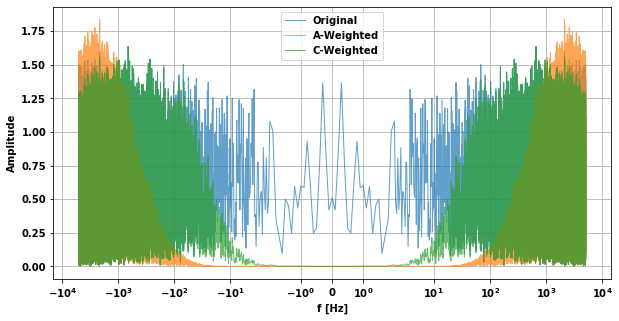

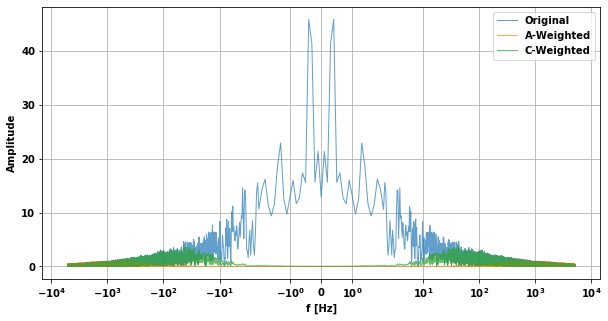

In [9]:
L = 10 # [s]
fs = 10240 # [hz]
N = int(L/(1/fs));  # generate the number of points based on the sampling frequency which is higher than the actual signal frequency
f_sin = 400;
df = fs/N
dt = L/N
Tp = 3

for i,s in enumerate([s0,s1]):
    freq = s.X.index.values
    Ha, Hc = SignalTB.filter_ha_hc(freq) #create filter
    s_ha = s.X.values * Ha[np.abs(freq)].values #apply the filter
    s_ha = pd.Series(data=s_ha,index=freq)

    s_hc = s.X.values * Hc[np.abs(freq)].values #apply the filter
    s_hc = pd.Series(data=s_hc,index=freq)

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.abs(s.X),alpha=0.7)
    plt.plot(np.abs(s_ha),alpha=0.7)
    plt.plot(np.abs(s_hc),alpha=0.7)
    plt.ylabel('Amplitude'); plt.xlabel('f [Hz]');
    plt.xscale('symlog'); plt.grid()
    plt.legend(['Original','A-Weighted','C-Weighted']);
    
    #SLV
    print('Original SPL:   {}'.format(SignalTB.spl(np.abs(SignalTB.my_ifft(X=s.X, N=N, df=df, dt=dt)))))
    print('A-Weighted SPL: {}'.format(SignalTB.spl(np.abs(SignalTB.my_ifft(X=s_ha, N=N, df=df, dt=dt)))))
    print('C-Weighted SPL: {}'.format(SignalTB.spl(np.abs(SignalTB.my_ifft(X=s_hc, N=N, df=df, dt=dt)))))
    fig.savefig('./plots/hw6_X'+str(i)+'.png', dpi=300, bbox_inches='tight')

# PART D: BUTTERWORTH

/home/m4rz910/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


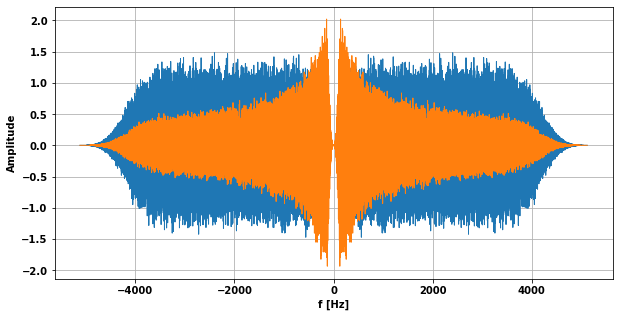

In [10]:
#checking if the whole band works
fig = plt.figure(figsize=(10,5))
for s in [s0,s1]:
    x = SignalTB.butter_bandpass_filter(data=s.x.values, lowcut=125, highcut=4000, fs=fs, order=3)
    x = pd.Series(data=x, index=s.x.index)
    s = SignalTB(x=x, fs=fs)
    plt.plot(s.my_fft())
plt.ylabel('Amplitude'); plt.xlabel('f [Hz]');
plt.grid()

# PART E: OCTAVE BANDS

[125, 250, 500, 1000, 2000]

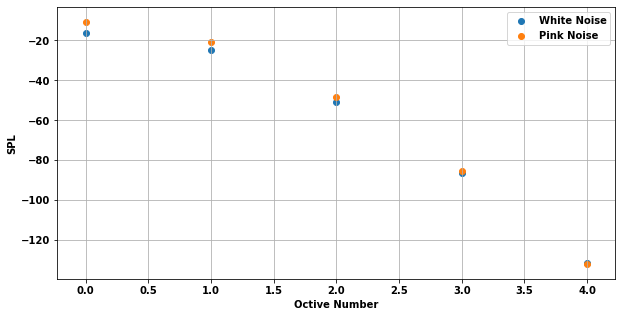

In [11]:
lowcut  = 125
highcut = 4000

cuts =  [lowcut*2**i for i in range(0,5)]
display(cuts)

fig = plt.figure(figsize=(10,5))
for s in [s0,s1]:
    octives = []
    for i,dummy in enumerate(cuts):
        x = SignalTB.butter_bandpass_filter(data=s.x.values,
                                            lowcut=cuts[i]/np.sqrt(2), highcut=cuts[i]*np.sqrt(2),
                                            fs=fs, order=3)
        x = pd.Series(data=x, index=s.x.index)
        s = SignalTB(x=x, fs=fs)
        X = s.my_fft()
        octives.append((i, SignalTB.spl(np.abs(SignalTB.my_ifft(X=X, N=N, df=df, dt=dt)))))
    plt.scatter(*zip(*octives));
plt.grid(); plt.xlabel('Octive Number'); plt.ylabel('SPL'); plt.legend(['White Noise','Pink Noise']);
fig.savefig('./plots/hw6_octives.png', dpi=300, bbox_inches='tight')

/home/m4rz910/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


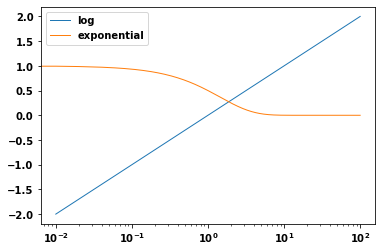

In [26]:
x = np.linspace(0,100,10000)
y_log = np.log10(x) #log cant have negatives
plt.plot(x, y_log, label='log');
plt.plot(x, 2**(-x),label='exponential')
plt.legend()
plt.xscale('log');

# Excercise: Calculating Reveration Time

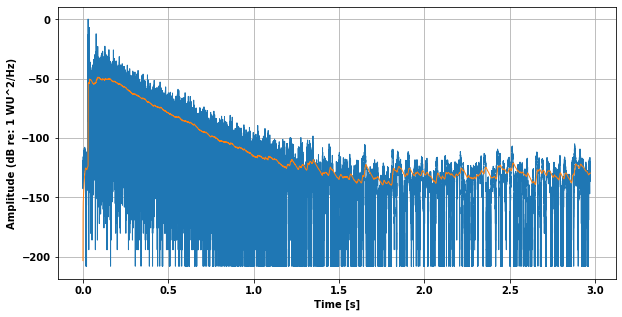

In [85]:
def filter_exponential(x,dt,Tc):
    a = (1,dt/Tc-1)
    b = (0, dt/Tc)
    return pd.Series(data = signal.lfilter(b, a, x.values**2),
                     index = x.index)

data, fs = sf.read(filename)
N = len(data)
L = N/fs
x = pd.Series(data=[channels[0] for channels in data],
              index=np.linspace(start=0, stop=L, num=N, endpoint=True),
              name='time domain signal')

s = SignalTB(x=x,fs=fs)
exp = filter_exponential(s.x,dt=s.dt,Tc=0.03)

#plot exponential filter
plt.figure(figsize=(10,5))
plt.plot(10*np.log(s.x**2)); 
plt.plot(10*np.log(exp))
plt.ylabel('Amplitude (dB re: 1 WU^2/Hz)'); plt.xlabel('Time [s]'); plt.grid();

#calculate reverberation time
#calculate this manually.

#schrodiner
